# KMP Legundi

# Import Library

In [1]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold , cross_val_score
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score , average_precision_score 
from sklearn.ensemble import RandomForestClassifier
from mlxtend.plotting import plot_confusion_matrix
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report
from warnings import simplefilter
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.metrics import ConfusionMatrixDisplay


from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error

# Read Data

In [2]:
import pandas as pd
df = pd.read_csv("C:/Users/Lenovo/OneDrive - db/Dattabot 1/AI LLM/Anomali Detection/kmp_legundi_dataset.csv")
df = df[["Timestamp", "temperature_exh1"]]
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df

Timestamp  temperature_exh1
0   2024-12-13 14:00:00               378
1   2024-12-13 15:00:00               150
2   2024-12-13 16:00:00               454
3   2024-12-13 17:00:00               170
4   2024-12-13 18:00:00               143
..                  ...               ...
598 2025-01-07 12:00:00               172
599 2025-01-07 13:00:00               452
600 2025-01-07 14:00:00               290
601 2025-01-07 15:00:00               211
602 2025-01-07 16:00:00               460

[603 rows x 2 columns]

# Membuat Label (<=450:0, >450:1)

In [3]:
df['label'] = df['temperature_exh1'].apply(lambda x : 1 if x > 450 else 0)
df

Timestamp  temperature_exh1  label
0   2024-12-13 14:00:00               378      0
1   2024-12-13 15:00:00               150      0
2   2024-12-13 16:00:00               454      1
3   2024-12-13 17:00:00               170      0
4   2024-12-13 18:00:00               143      0
..                  ...               ...    ...
598 2025-01-07 12:00:00               172      0
599 2025-01-07 13:00:00               452      1
600 2025-01-07 14:00:00               290      0
601 2025-01-07 15:00:00               211      0
602 2025-01-07 16:00:00               460      1

[603 rows x 3 columns]

In [4]:
df['label'].value_counts()

label
0    526
1     77
Name: count, dtype: int64

# Feature Engineering

In [5]:
data = df.copy()

data['MA_3h'] = data['temperature_exh1'].rolling(window=3).mean()
data['MA_4h'] = data['temperature_exh1'].rolling(window=4).mean()
data['Rol_STD_3h'] = data['temperature_exh1'].rolling(window=3).std()
data['Rol_STD_4h'] = data['temperature_exh1'].rolling(window=4).std()
data['ROC'] = data['temperature_exh1'].diff()
data

Timestamp  temperature_exh1  label       MA_3h   MA_4h  \
0   2024-12-13 14:00:00               378      0         NaN     NaN   
1   2024-12-13 15:00:00               150      0         NaN     NaN   
2   2024-12-13 16:00:00               454      1  327.333333     NaN   
3   2024-12-13 17:00:00               170      0  258.000000  288.00   
4   2024-12-13 18:00:00               143      0  255.666667  229.25   
..                  ...               ...    ...         ...     ...   
598 2025-01-07 12:00:00               172      0  259.333333  263.50   
599 2025-01-07 13:00:00               452      1  359.666667  307.50   
600 2025-01-07 14:00:00               290      0  304.666667  342.25   
601 2025-01-07 15:00:00               211      0  317.666667  281.25   
602 2025-01-07 16:00:00               460      1  320.333333  353.25   

     Rol_STD_3h  Rol_STD_4h    ROC  
0           NaN         NaN    NaN  
1           NaN         NaN -228.0  
2    158.206616         NaN  304.0  
3    170.035290  151.243733 -284.0  
4    172.291420  150.269480  -27.0  
..          ...         ...    ...  
598  169.777305  138.872844 -283.0  
599  162.531023  168.808570  280.0  
600  140.575010  137.201494 -162.0  
601  122.858998  123.966057  -79.0  
602  127.241241  122.994241  249.0  

[603 rows x 8 columns]

In [6]:
cek = data[data['label']==1]
cek

Timestamp  temperature_exh1  label       MA_3h   MA_4h  \
2   2024-12-13 16:00:00               454      1  327.333333     NaN   
29  2024-12-14 19:00:00               463      1  366.333333  328.50   
32  2024-12-14 22:00:00               469      1  341.333333  371.75   
46  2024-12-15 12:00:00               460      1  274.333333  314.25   
52  2024-12-15 18:00:00               456      1  261.333333  304.25   
..                  ...               ...    ...         ...     ...   
589 2025-01-07 03:00:00               454      1  361.666667  353.75   
592 2025-01-07 06:00:00               458      1  265.666667  312.75   
597 2025-01-07 11:00:00               455      1  294.000000  332.00   
599 2025-01-07 13:00:00               452      1  359.666667  307.50   
602 2025-01-07 16:00:00               460      1  320.333333  353.25   

     Rol_STD_3h  Rol_STD_4h    ROC  
2    158.206616         NaN  304.0  
29   155.464894  147.777987   14.0  
32   145.445293  133.430069   97.0  
46   165.814153  157.171615  319.0  
52   169.653569  162.958839  311.0  
..          ...         ...    ...  
589  165.149427  135.770333  283.0  
592  167.822327  166.263596  309.0  
597  152.797251  146.084450  304.0  
599  162.531023  168.808570  280.0  
602  127.241241  122.994241  249.0  

[77 rows x 8 columns]

In [29]:
data.head(450)

Timestamp  temperature_exh1  label  MA_3h  MA_4h  Rol_STD_3h  \
0   2024-12-13 14:00:00               378      0    NaN    NaN         NaN   
1   2024-12-13 15:00:00               150      0    NaN    NaN         NaN   
2   2024-12-13 16:00:00               454      1 327.33    NaN      158.21   
3   2024-12-13 17:00:00               170      0 258.00 288.00      170.04   
4   2024-12-13 18:00:00               143      0 255.67 229.25      172.29   
..                  ...               ...    ...    ...    ...         ...   
445 2025-01-01 03:00:00                 0      0 138.67 215.75      120.69   
446 2025-01-01 04:00:00                 0      0  73.33 104.00      127.02   
447 2025-01-01 05:00:00                 0      0   0.00  55.00        0.00   
448 2025-01-01 06:00:00                 0      0   0.00   0.00        0.00   
449 2025-01-01 07:00:00                 0      0   0.00   0.00        0.00   

     Rol_STD_4h     ROC  
0           NaN     NaN  
1           NaN -228.00  
2           NaN  304.00  
3        151.24 -284.00  
4        150.27  -27.00  
..          ...     ...  
445      182.97 -220.00  
446      120.49    0.00  
447      110.00    0.00  
448        0.00    0.00  
449        0.00    0.00  

[450 rows x 8 columns]

# Model Supervised

## 1. MA 3h

In [211]:
data_MA_3h = data.copy()
features_MA_3h = ['MA_3h']
target_column = ['label']
timestamp = data_MA_3h['Timestamp']
                
data_MA_3h = data_MA_3h.dropna(subset=(features_MA_3h))


### Train Test Split

In [212]:
# Train-Test Split Secara Berurutan (80% Train, 20% Test)
split_index = int(len(data_MA_3h) * 0.8)
X_train, X_test = data_MA_3h.iloc[:split_index][features_MA_3h], data_MA_3h.iloc[split_index:][features_MA_3h]
y_train, y_test = data_MA_3h.iloc[:split_index][target_column], data_MA_3h.iloc[split_index:][target_column]
timestamps_train, timestamps_test = timestamp[:split_index], timestamp[split_index:]

### Standarisasi (Opsional)

In [10]:
from sklearn.preprocessing import StandardScaler

# Standarisasi
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### SMOTE

In [34]:
# Terapkan SMOTE hanya ke data train (only smote tanpa standarisasi)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Terapkan SMOTE hanya ke data train (smote dan standarisasi)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

### Lazy Predict

In [ ]:
## TIDAK PAKEK SMOTE

from lazypredict.Supervised import LazyClassifier

from sklearn.model_selection import train_test_split

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
model_dictionary = clf.provide_models(X_train,X_test,y_train,y_test)
models

## MENGGUNAKAN SMOTE

# clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
# models, predictions = clf.fit(X_train_resampled, X_test, y_train_resampled, y_test)
# model_dictionary = clf.provide_models(X_train_resampled,X_test,y_train_resampled,y_test)
# models

  0%|          | 0/29 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 20.05it/s]

[LightGBM] [Info] Number of positive: 47, number of negative: 433
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 143
[LightGBM] [Info] Number of data points in the train set: 480, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.097917 -> initscore=-2.220590
[LightGBM] [Info] Start training from score -2.220590
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
NearestCentroid                    0.60               0.61     0.61      0.63   
PassiveAggressiveClassifier        0.44               0.59     0.59      0.44   
AdaBoostClassifier                 0.75               0.50     0.50      0.65   
LinearDiscriminantAnalysis         0.75               0.50     0.50      0.65   
SVC                                0.75               0.50     0.50      0.65   
SGDClassifier                      0.75               0.50     0.50      0.65   
RidgeClassifierCV                  0.75               0.50     0.50      0.65   
RidgeClassifier                    0.75               0.50     0.50      0.65   
QuadraticDiscriminantAnalysis      0.75               0.50     0.50      0.65   
Perceptron                         0.75               0.50     0.50      0.65   
LogisticRegression                 0.75               0.50     0.50      0.65   
LinearSVC                          0.75               0.50     0.50      0.65   
LabelSpreading                     0.75               0.50     0.50      0.65   
LabelPropagation                   0.75               0.50     0.50      0.65   
KNeighborsClassifier               0.75               0.50     0.50      0.65   
GaussianNB                         0.75               0.50     0.50      0.65   
DummyClassifier                    0.75               0.50     0.50      0.65   
CalibratedClassifierCV             0.75               0.50     0.50      0.65   
BernoulliNB                        0.75               0.50     0.50      0.65   
LGBMClassifier                     0.75               0.50     0.50      0.65   
XGBClassifier                      0.74               0.49     0.49      0.64   
ExtraTreesClassifier               0.74               0.49     0.49      0.64   
ExtraTreeClassifier                0.74               0.49     0.49      0.64   
RandomForestClassifier             0.74               0.49     0.49      0.64   
DecisionTreeClassifier             0.74               0.49     0.49      0.64   
BaggingClassifier                  0.73               0.48     0.48      0.63   

                               Time Taken  
Model                                      
NearestCentroid                      0.12  
PassiveAggressiveClassifier          0.01  
AdaBoostClassifier                   0.16  
LinearDiscriminantAnalysis           0.03  
SVC                                  0.02  
SGDClassifier                        0.02  
RidgeClassifierCV                    0.03  
RidgeClassifier                      0.02  
QuadraticDiscriminantAnalysis        0.02  
Perceptron                           0.03  
LogisticRegression                   0.03  
LinearSVC                            0.02  
LabelSpreading                       0.04  
LabelPropagation                     0.03  
KNeighborsClassifier                 0.03  
GaussianNB                           0.02  
DummyClassifier                      0.01  
CalibratedClassifierCV               0.05  
BernoulliNB                          0.02  
LGBMClassifier                       0.08  
XGBClassifier                        0.12  
ExtraTreesClassifier                 0.17  
ExtraTreeClassifier                  0.01  
RandomForestClassifier               0.23  
DecisionTreeClassifier               0.03  
BaggingClassifier                    0.05

#### Random Forest

In [214]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Pilihan apakah ingin menggunakan hyperparameter tuning atau tidak
use_hypertuning = True  # Ganti ke False jika ingin menggunakan RandomForestClassifier default

# Jika menggunakan hyperparameter tuning RandomForestClassifier
if use_hypertuning:
    param_grid = {
        'n_estimators': [50, 100, 200],  
        'max_depth': [10, 20, 30, None],  
        'min_samples_split': [2, 5, 10],  
        'min_samples_leaf': [1, 2, 5, 10],  
        'max_features': ['sqrt', 'log2', None],  
        'bootstrap': [True, False]  
    }
    
    grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    # Ambil model terbaik dari hasil tuning
    best_params = grid_search.best_params_
    print("Best Hyperparameters:", best_params)
    clf_rf = grid_search.best_estimator_
    
else:
    # Jika tanpa hypertuning, gunakan model default
    clf_rf = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_split=5, 
                                   min_samples_leaf=2, criterion='gini', bootstrap=True, 
                                   random_state=42, n_jobs=-1)

# Latih model menggunakan data training
clf_rf.fit(X_train, y_train)

# Lakukan prediksi pada data train dan test
y_train_pred = clf_rf.predict(X_train)
y_test_pred = clf_rf.predict(X_test)

# Evaluasi model
print("\nTrain Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))


Fitting 3 folds for each of 864 candidates, totalling 2592 fits
Best Hyperparameters: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 50}

Train Accuracy: 0.9020833333333333
Test Accuracy: 0.7520661157024794

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.75      1.00      0.86        91
           1       0.00      0.00      0.00        30

    accuracy                           0.75       121
   macro avg       0.38      0.50      0.43       121
weighted avg       0.57      0.75      0.65       121



#### Adaboost Classifier

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Pilihan apakah ingin menggunakan hyperparameter tuning atau tidak
use_hypertuning = True  # Ganti ke True jika ingin menggunakan tuning

# Jika menggunakan hyperparameter tuning AdaBoost
if use_hypertuning:
    param_grid = {
        'n_estimators': [50, 100, 200],  # Jumlah estimator (jumlah model weak learner)
        'learning_rate': [0.01, 0.1, 1.0]  # Kecepatan belajar
    }
    
    grid_search = GridSearchCV(AdaBoostClassifier(), param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    # Ambil model terbaik dari hasil tuning
    best_params = grid_search.best_params_
    print("Best Hyperparameters:", best_params)
    clf_adaboost = grid_search.best_estimator_
    
else:
    # Jika tanpa hypertuning, gunakan model default
    clf_adaboost = AdaBoostClassifier(n_estimators=100, learning_rate=1.0, random_state=42)

# Latih model menggunakan data training
clf_adaboost.fit(X_train, y_train)

# Lakukan prediksi pada data train dan test
y_train_pred = clf_adaboost.predict(X_train)
y_test_pred = clf_adaboost.predict(X_test)

# Evaluasi model
print("\nTrain Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))


Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Hyperparameters: {'learning_rate': 0.01, 'n_estimators': 50}

Train Accuracy: 0.9044444444444445
Test Accuracy: 0.78

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.78      1.00      0.88       117
           1       0.00      0.00      0.00        33

    accuracy                           0.78       150
   macro avg       0.39      0.50      0.44       150
weighted avg       0.61      0.78      0.68       150



#### SVC

tanpa tuning

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Pilihan apakah ingin menggunakan hyperparameter tuning atau tidak
use_hypertuning = False  # Ganti ke False jika ingin menggunakan SVC default

# Jika menggunakan hyperparameter tuning SVC
if use_hypertuning:
    param_grid = {
        'C': [0.1, 1, 10],  
        'kernel': ['linear', 'rbf'],  
        'gamma': ['scale', 'auto']
    }
    
    grid_search = GridSearchCV(SVC(), param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    # Ambil model terbaik dari hasil tuning
    best_params = grid_search.best_params_
    print("Best Hyperparameters:", best_params)
    clf_svc = grid_search.best_estimator_
    
else:
    # Jika tanpa hypertuning, gunakan model default
    clf_svc = SVC(C=1.0, kernel='rbf', gamma='auto', random_state=42)

# Latih model menggunakan data training
clf_svc.fit(X_train, y_train)

# Lakukan prediksi pada data train dan test
y_train_pred = clf_svc.predict(X_train)
y_test_pred = clf_svc.predict(X_test)

# Evaluasi model
print("\nTrain Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))



Train Accuracy: 0.9066666666666666
Test Accuracy: 0.7733333333333333

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.78      0.99      0.87       117
           1       0.00      0.00      0.00        33

    accuracy                           0.77       150
   macro avg       0.39      0.50      0.44       150
weighted avg       0.61      0.77      0.68       150



dengan tuning

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Pilihan apakah ingin menggunakan hyperparameter tuning atau tidak
use_hypertuning = True  # Ganti ke False jika ingin menggunakan SVC default

# Jika menggunakan hyperparameter tuning
if use_hypertuning:
    param_grid = {
        'C': [0.1, 1, 10],  
        'kernel': ['linear', 'rbf'],  
        'gamma': ['scale', 'auto']
    }
    
    grid_search = GridSearchCV(SVC(), param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    # Ambil model terbaik dari hasil tuning
    best_params = grid_search.best_params_
    print("Best Hyperparameters:", best_params)
    clf_svc = grid_search.best_estimator_
    
else:
    # Jika tanpa hypertuning, gunakan model default
    clf_svc = SVC(C=1.0, kernel='rbf', gamma='scale', random_state=42)

# Latih model menggunakan data training
clf_svc.fit(X_train, y_train)

# Lakukan prediksi pada data train dan test
y_train_pred = clf_svc.predict(X_train)
y_test_pred = clf_svc.predict(X_test)

# Evaluasi model
print("\nTrain Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Hyperparameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}

Train Accuracy: 0.9044444444444445
Test Accuracy: 0.78

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.78      1.00      0.88       117
           1       0.00      0.00      0.00        33

    accuracy                           0.78       150
   macro avg       0.39      0.50      0.44       150
weighted avg       0.61      0.78      0.68       150



#### XGboost

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Pilihan apakah ingin menggunakan hyperparameter tuning atau tidak
use_hypertuning = True  # Ganti ke False jika ingin menggunakan XGBClassifier default

# Jika menggunakan hyperparameter tuning
if use_hypertuning:
    param_grid = {
        'n_estimators': [25, 50, 100],  
        'learning_rate': [0.1,0.01 , 0.05],  
        'max_depth': [3, 5, 10]
    }
    
    grid_search = GridSearchCV(XGBClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    # Ambil model terbaik dari hasil tuning
    best_params = grid_search.best_params_
    print("Best Hyperparameters:", best_params)
    clf_xgb = grid_search.best_estimator_
    
else:
    # Jika tanpa hypertuning, gunakan model default
    clf_xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Latih model menggunakan data training
clf_xgb.fit(X_train, y_train)

# Lakukan prediksi pada data train dan test
y_train_pred = clf_xgb.predict(X_train)
y_test_pred = clf_xgb.predict(X_test)

# Evaluasi model
print("\nTrain Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 25}

Train Accuracy: 0.9024896265560166
Test Accuracy: 0.7520661157024794

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.75      1.00      0.86        91
           1       0.00      0.00      0.00        30

    accuracy                           0.75       121
   macro avg       0.38      0.50      0.43       121
weighted avg       0.57      0.75      0.65       121



#### Decission Tree

In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Pilihan apakah ingin menggunakan hyperparameter tuning atau tidak
use_hypertuning = False  # Ganti ke False jika ingin menggunakan DecisionTreeClassifier default

# Jika menggunakan hyperparameter tuning DecisionTreeClassifier
if use_hypertuning:
    param_grid = {
        'criterion': ['gini', 'entropy'],  
        'max_depth': [5, 10, 20, None],  
        'min_samples_split': [2, 5, 10],  
        'min_samples_leaf': [1, 2, 5, 10],  
        'max_features': ['sqrt', 'log2', None]  
    }
    
    grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    # Ambil model terbaik dari hasil tuning
    best_params = grid_search.best_params_
    print("Best Hyperparameters:", best_params)
    clf_dt = grid_search.best_estimator_
    
else:
    # Jika tanpa hypertuning, gunakan model default
    clf_dt = DecisionTreeClassifier(random_state=42, max_depth=10, min_samples_split=5, criterion='gini')

# Latih model menggunakan data training
clf_dt.fit(X_train, y_train)

# Lakukan prediksi pada data train dan test
y_train_pred = clf_dt.predict(X_train)
y_test_pred = clf_dt.predict(X_test)

# Evaluasi model
print("\nTrain Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))



Train Accuracy: 0.9208333333333333
Test Accuracy: 0.7355371900826446

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.75      0.98      0.85        91
           1       0.00      0.00      0.00        30

    accuracy                           0.74       121
   macro avg       0.37      0.49      0.42       121
weighted avg       0.56      0.74      0.64       121



#### Bagging Classifier

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Pilihan apakah ingin menggunakan hyperparameter tuning atau tidak
use_hypertuning = False  # Ganti ke False jika ingin menggunakan model default

# Inisialisasi model dasar (base estimator) untuk Bagging
base_estimator = DecisionTreeClassifier(random_state=42)

if use_hypertuning:
    # GridSearchCV - Hyperparameter tuning untuk BaggingClassifier
    param_grid = {
        'n_estimators': [10, 50, 100],  # Jumlah model dalam ensemble
        'max_samples': [0.5, 0.8, 1.0],  # Proporsi sampel yang digunakan setiap model
        'max_features': [0.5, 0.8, 1.0],  # Proporsi fitur yang digunakan setiap model
        'bootstrap': [True, False]  # Sampling dengan atau tanpa pengembalian
    }

    # Inisialisasi model BaggingClassifier
    bagging = BaggingClassifier(base_estimator=base_estimator, random_state=42)

    # Grid Search dengan 5-fold cross-validation
    grid_search = GridSearchCV(bagging, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    # Mengambil hyperparameter terbaik
    best_params = grid_search.best_params_
    print("Best Hyperparameters:", best_params)

    # Menggunakan model terbaik hasil tuning
    model = grid_search.best_estimator_

else:
    # Jika tanpa hypertuning, gunakan model default
    model = BaggingClassifier(base_estimator=base_estimator, n_estimators=50, max_samples=1.0, 
                              max_features=1.0, bootstrap=True, random_state=42)
    model.fit(X_train, y_train)

# Prediksi pada train dan test set
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Evaluasi model
print("\nTrain Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))



Train Accuracy: 0.9229166666666667
Test Accuracy: 0.7333333333333333

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.75      0.97      0.85        91
           1       0.00      0.00      0.00        29

    accuracy                           0.73       120
   macro avg       0.38      0.48      0.42       120
weighted avg       0.57      0.73      0.64       120



## 2. STD 3h

In [120]:
data_Rol_STD_3h = data.copy()
features_Rol_STD_3h = ['Rol_STD_3h']
target_column = ['label']
timestamp = data_Rol_STD_3h['Timestamp']
                
data_Rol_STD_3h = data_Rol_STD_3h.dropna()

# Fix Error: Konversi Timestamp ke datetime sebelum pakai .timestamp()

### Train Test Split

In [121]:
# Train-Test Split Secara Berurutan (80% Train, 20% Test)

split_index = int(len(data_Rol_STD_3h) * 0.8)
X_train, X_test = data_Rol_STD_3h.iloc[:split_index][features_Rol_STD_3h], data_Rol_STD_3h.iloc[split_index:][features_Rol_STD_3h]
y_train, y_test = data_Rol_STD_3h.iloc[:split_index][target_column], data_Rol_STD_3h.iloc[split_index:][target_column]
timestamps_train, timestamps_test = timestamp[:split_index], timestamp[split_index:]

In [111]:
from sklearn.preprocessing import StandardScaler

# Standarisasi
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [20]:
# Terapkan SMOTE hanya ke data train (only smote tanpa standarisasi)
smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Terapkan SMOTE hanya ke data train (smote dan standarisasi)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

In [122]:
## TIDAK PAKEK SMOTE
from lazypredict.Supervised import LazyClassifier

from sklearn.model_selection import train_test_split

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
model_dictionary = clf.provide_models(X_train,X_test,y_train,y_test)
models

## MENGGUNAKAN SMOTE

# clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
# models, predictions = clf.fit(X_train_resampled, X_test, y_train_resampled, y_test)
# model_dictionary = clf.provide_models(X_train_resampled,X_test,y_train_resampled,y_test)
# models

# # Tidak pakek smote tapi std
# clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
# models, predictions = clf.fit(X_train_scaled, X_test_scaled, y_train, y_test)
# model_dictionary = clf.provide_models(X_train_scaled,X_test_scaled,y_train,y_test)
# models

100%|██████████| 29/29 [00:01<00:00, 20.56it/s]

[LightGBM] [Info] Number of positive: 47, number of negative: 433
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 480, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.097917 -> initscore=-2.220590
[LightGBM] [Info] Start training from score -2.220590
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
NearestCentroid                    0.52               0.60     0.60      0.54   
PassiveAggressiveClassifier        0.63               0.54     0.54      0.64   
Perceptron                         0.75               0.52     0.52      0.68   
KNeighborsClassifier               0.75               0.51     0.51      0.66   
LGBMClassifier                     0.74               0.50     0.50      0.66   
XGBClassifier                      0.74               0.50     0.50      0.66   
LogisticRegression                 0.76               0.50     0.50      0.65   
SVC                                0.76               0.50     0.50      0.65   
SGDClassifier                      0.76               0.50     0.50      0.65   
RidgeClassifierCV                  0.76               0.50     0.50      0.65   
RidgeClassifier                    0.76               0.50     0.50      0.65   
QuadraticDiscriminantAnalysis      0.76               0.50     0.50      0.65   
LinearSVC                          0.76               0.50     0.50      0.65   
LinearDiscriminantAnalysis         0.76               0.50     0.50      0.65   
LabelSpreading                     0.76               0.50     0.50      0.65   
LabelPropagation                   0.76               0.50     0.50      0.65   
GaussianNB                         0.76               0.50     0.50      0.65   
DummyClassifier                    0.76               0.50     0.50      0.65   
CalibratedClassifierCV             0.76               0.50     0.50      0.65   
BernoulliNB                        0.76               0.50     0.50      0.65   
BaggingClassifier                  0.73               0.50     0.50      0.65   
ExtraTreeClassifier                0.74               0.49     0.49      0.65   
AdaBoostClassifier                 0.74               0.49     0.49      0.65   
ExtraTreesClassifier               0.72               0.48     0.48      0.64   
RandomForestClassifier             0.72               0.48     0.48      0.64   
DecisionTreeClassifier             0.72               0.48     0.48      0.64   

                               Time Taken  
Model                                      
NearestCentroid                      0.13  
PassiveAggressiveClassifier          0.02  
Perceptron                           0.02  
KNeighborsClassifier                 0.03  
LGBMClassifier                       0.08  
XGBClassifier                        0.11  
LogisticRegression                   0.03  
SVC                                  0.04  
SGDClassifier                        0.01  
RidgeClassifierCV                    0.02  
RidgeClassifier                      0.04  
QuadraticDiscriminantAnalysis        0.02  
LinearSVC                            0.03  
LinearDiscriminantAnalysis           0.02  
LabelSpreading                       0.03  
LabelPropagation                     0.03  
GaussianNB                           0.02  
DummyClassifier                      0.02  
CalibratedClassifierCV               0.06  
BernoulliNB                          0.02  
BaggingClassifier                    0.04  
ExtraTreeClassifier                  0.02  
AdaBoostClassifier                   0.18  
ExtraTreesClassifier                 0.14  
RandomForestClassifier               0.19  
DecisionTreeClassifier               0.01

### SVC

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Pilihan apakah ingin menggunakan hyperparameter tuning atau tidak
use_hypertuning = True  # Ganti ke False jika ingin menggunakan SVC default

# Jika menggunakan hyperparameter tuning
if use_hypertuning:
    param_grid = {
        'C': [0.1, 1, 10],  
        'kernel': ['linear', 'rbf'],  
        'gamma': ['scale', 'auto']
    }
    
    grid_search = GridSearchCV(SVC(), param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    # Ambil model terbaik dari hasil tuning
    best_params = grid_search.best_params_
    print("Best Hyperparameters:", best_params)
    clf_svc = grid_search.best_estimator_
    
else:
    # Jika tanpa hypertuning, gunakan model default
    clf_svc = SVC(C=1.0, kernel='rbf', gamma='scale', random_state=42)

# Latih model menggunakan data training
clf_svc.fit(X_train, y_train)

# Lakukan prediksi pada data train dan test
y_train_pred = clf_svc.predict(X_train)
y_test_pred = clf_svc.predict(X_test)

# Evaluasi model
print("\nTrain Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Hyperparameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}

Train Accuracy: 0.9020833333333333
Test Accuracy: 0.7583333333333333

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.76      1.00      0.86        91
           1       0.00      0.00      0.00        29

    accuracy                           0.76       120
   macro avg       0.38      0.50      0.43       120
weighted avg       0.58      0.76      0.65       120



### Gaussian NB

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Pilihan apakah ingin menggunakan hyperparameter tuning atau tidak
use_hypertuning = True  # Ganti ke False jika ingin menggunakan GaussianNB default

# Jika menggunakan hyperparameter tuning
if use_hypertuning:
    param_grid = {
        'var_smoothing': [1e-12, 1e-10, 1e-8, 1e-6, 1e-4, 1e-2]
    }
    
    grid_search = GridSearchCV(GaussianNB(), param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    # Ambil model terbaik dari hasil tuning
    best_params = grid_search.best_params_
    print("Best Hyperparameters:", best_params)
    clf_GaussianNB = grid_search.best_estimator_
    
else:
    # Jika tanpa hypertuning, gunakan model default
    clf_GaussianNB = GaussianNB(C=1.0, kernel='rbf', gamma='scale', random_state=42)

# Latih model menggunakan data training
clf_GaussianNB.fit(X_train, y_train)

# Lakukan prediksi pada data train dan test
y_train_pred = clf_GaussianNB.predict(X_train)
y_test_pred = clf_GaussianNB.predict(X_test)

# Evaluasi model
print("\nTrain Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))


Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Hyperparameters: {'var_smoothing': 1e-12}

Train Accuracy: 0.9020833333333333
Test Accuracy: 0.7583333333333333

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.76      1.00      0.86        91
           1       0.00      0.00      0.00        29

    accuracy                           0.76       120
   macro avg       0.38      0.50      0.43       120
weighted avg       0.58      0.76      0.65       120



## 3. MA 3h + Suhu

In [170]:
data_MA_3h_suhu = data.copy()
features_columns = ['MA_3h','temperature_exh1']
target_column = ['label']
timestamp = data['Timestamp']
                
data_MA_3h_suhu = data_MA_3h_suhu.dropna(subset=(features_columns)).reset_index(drop=True)


### Train Test Split

In [171]:
# Train-Test Split Secara Berurutan (80% Train, 20% Test)
split_index = int(len(data_MA_3h_suhu) * 0.8)
X_train, X_test = data_MA_3h_suhu.iloc[:split_index][features_columns], data_MA_3h_suhu.iloc[split_index:][features_columns]
y_train, y_test = data_MA_3h_suhu.iloc[:split_index][target_column], data_MA_3h_suhu.iloc[split_index:][target_column]
timestamps_train, timestamps_test = timestamp[:split_index], timestamp[split_index:]

### Lazy Predict

In [172]:
## TIDAK PAKEK SMOTE
from lazypredict.Supervised import LazyClassifier

from sklearn.model_selection import train_test_split

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
model_dictionary = clf.provide_models(X_train,X_test,y_train,y_test)
models

## MENGGUNAKAN SMOTE

# clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
# models, predictions = clf.fit(X_train_resampled, X_test, y_train_resampled, y_test)
# model_dictionary = clf.provide_models(X_train_resampled,X_test,y_train_resampled,y_test)
# models

100%|██████████| 29/29 [00:01<00:00, 22.46it/s]


[LightGBM] [Info] Number of positive: 47, number of negative: 433
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 251
[LightGBM] [Info] Number of data points in the train set: 480, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.097917 -> initscore=-2.220590
[LightGBM] [Info] Start training from score -2.220590
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
AdaBoostClassifier                 1.00               1.00     1.00      1.00   
BaggingClassifier                  1.00               1.00     1.00      1.00   
XGBClassifier                      1.00               1.00     1.00      1.00   
RandomForestClassifier             1.00               1.00     1.00      1.00   
Perceptron                         1.00               1.00     1.00      1.00   
LGBMClassifier                     1.00               1.00     1.00      1.00   
DecisionTreeClassifier             1.00               1.00     1.00      1.00   
QuadraticDiscriminantAnalysis      0.98               0.98     0.98      0.98   
PassiveAggressiveClassifier        0.97               0.98     0.98      0.97   
GaussianNB                         0.97               0.98     0.98      0.97   
ExtraTreesClassifier               0.98               0.97     0.97      0.98   
NearestCentroid                    0.82               0.88     0.88      0.83   
ExtraTreeClassifier                0.90               0.80     0.80      0.89   
KNeighborsClassifier               0.86               0.73     0.73      0.84   
SGDClassifier                      0.83               0.67     0.67      0.80   
LinearSVC                          0.78               0.55     0.55      0.70   
DummyClassifier                    0.75               0.50     0.50      0.65   
LogisticRegression                 0.75               0.50     0.50      0.65   
LinearDiscriminantAnalysis         0.75               0.50     0.50      0.65   
LabelSpreading                     0.75               0.50     0.50      0.65   
LabelPropagation                   0.75               0.50     0.50      0.65   
CalibratedClassifierCV             0.75               0.50     0.50      0.65   
RidgeClassifier                    0.75               0.50     0.50      0.65   
RidgeClassifierCV                  0.75               0.50     0.50      0.65   
SVC                                0.75               0.50     0.50      0.65   
BernoulliNB                        0.75               0.50     0.50      0.65   

                               Time Taken  
Model                                      
AdaBoostClassifier                   0.06  
BaggingClassifier                    0.08  
XGBClassifier                        0.07  
RandomForestClassifier               0.19  
Perceptron                           0.02  
LGBMClassifier                       0.07  
DecisionTreeClassifier               0.02  
QuadraticDiscriminantAnalysis        0.03  
PassiveAggressiveClassifier          0.04  
GaussianNB                           0.03  
ExtraTreesClassifier                 0.17  
NearestCentroid                      0.02  
ExtraTreeClassifier                  0.01  
KNeighborsClassifier                 0.03  
SGDClassifier                        0.03  
LinearSVC                            0.03  
DummyClassifier                      0.02  
LogisticRegression                   0.03  
LinearDiscriminantAnalysis           0.04  
LabelSpreading                       0.04  
LabelPropagation                     0.02  
CalibratedClassifierCV               0.06  
RidgeClassifier                      0.04  
RidgeClassifierCV                    0.02  
SVC                                  0.03  
BernoulliNB                          0.04

#### QDA

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Pilihan apakah ingin menggunakan hyperparameter tuning atau tidak
use_hypertuning = True  # Ganti ke True jika ingin menggunakan tuning

# Jika menggunakan hyperparameter tuning AdaBoost
if use_hypertuning:
    param_grid = {
        'reg_param': [0.1, 0.5, 0.9]   
    }
    
    grid_search = GridSearchCV(QuadraticDiscriminantAnalysis(), param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    # Ambil model terbaik dari hasil tuning
    best_params = grid_search.best_params_
    print("Best Hyperparameters:", best_params)
    clf_qda = grid_search.best_estimator_
    
else:
    # Jika tanpa hypertuning, gunakan model default
    clf_qda = QuadraticDiscriminantAnalysis(reg_param = 0)

# Latih model menggunakan data training
clf_qda.fit(X_train, y_train)

# Lakukan prediksi pada data train dan test
y_train_pred = clf_qda.predict(X_train)
y_test_pred = clf_qda.predict(X_test)

# Evaluasi model
print("\nTrain Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))


Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best Hyperparameters: {'reg_param': 0.9}

Train Accuracy: 0.9645833333333333
Test Accuracy: 0.9917355371900827

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        91
           1       1.00      0.97      0.98        30

    accuracy                           0.99       121
   macro avg       0.99      0.98      0.99       121
weighted avg       0.99      0.99      0.99       121



#### PAC

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Pilihan apakah ingin menggunakan hyperparameter tuning atau tidak
use_hypertuning = True  # Ganti ke True jika ingin menggunakan tuning

# Jika menggunakan hyperparameter tuning AdaBoost
if use_hypertuning:
    param_grid = {
        "C": [0.001, 0.01, 0.08, 0.1, 1.0],  # Rentang nilai C
        "max_iter": [500, 1000, 2000],  # Iterasi maksimum
    }
    
    grid_search = GridSearchCV(PassiveAggressiveClassifier(), param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    # Ambil model terbaik dari hasil tuning
    best_params = grid_search.best_params_
    print("Best Hyperparameters:", best_params)
    clf_pac = grid_search.best_estimator_
    
else:
    # Jika tanpa hypertuning, gunakan model default
    clf_pac = PassiveAggressiveClassifier(C=0.08, max_iter=1000, random_state=42)

# Latih model menggunakan data training
clf_pac.fit(X_train, y_train)

# Lakukan prediksi pada data train dan test
y_train_pred = clf_pac.predict(X_train)
y_test_pred = clf_pac.predict(X_test)

# Evaluasi model
print("\nTrain Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))


Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best Hyperparameters: {'C': 0.1, 'max_iter': 1000}

Train Accuracy: 0.8854166666666666
Test Accuracy: 0.768595041322314

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.77      0.99      0.87        91
           1       0.75      0.10      0.18        30

    accuracy                           0.77       121
   macro avg       0.76      0.54      0.52       121
weighted avg       0.76      0.77      0.69       121



#### ExtraTress Classifier

In [83]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Pilihan apakah ingin menggunakan hyperparameter tuning atau tidak
use_hypertuning = True  # Ganti ke True jika ingin menggunakan tuning

# Jika menggunakan hyperparameter tuning AdaBoost
if use_hypertuning:
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 5],
        'max_features': ['sqrt', 'log2', None]
    }
    
    grid_search = GridSearchCV(ExtraTreesClassifier(), param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    # Ambil model terbaik dari hasil tuning
    best_params = grid_search.best_params_
    print("Best Hyperparameters:", best_params)
    clf_et = grid_search.best_estimator_
    
else:
    # Jika tanpa hypertuning, gunakan model default
    clf_et = ExtraTreesClassifier(n_estimators=50, max_depth=10, min_samples_leaf=5)

# Latih model menggunakan data training
clf_et.fit(X_train, y_train)

# Lakukan prediksi pada data train dan test
y_train_pred = clf_et.predict(X_train)
y_test_pred = clf_et.predict(X_test)

# Evaluasi model
print("\nTrain Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))


Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Hyperparameters: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}

Train Accuracy: 1.0
Test Accuracy: 1.0

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        91
           1       1.00      1.00      1.00        30

    accuracy                           1.00       121
   macro avg       1.00      1.00      1.00       121
weighted avg       1.00      1.00      1.00       121



#### Decission Tree

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Pilihan apakah ingin menggunakan hyperparameter tuning atau tidak
use_hypertuning = True  # Ganti ke False jika ingin menggunakan DecisionTreeClassifier default

# Jika menggunakan hyperparameter tuning DecisionTreeClassifier
if use_hypertuning:
    param_grid = {
        'criterion': ['gini', 'entropy'],  
        'max_depth': [5, 10, 20, None],  
        'min_samples_split': [2, 5, 10],  
        'min_samples_leaf': [1, 2, 5, 10],  
        'max_features': ['sqrt', 'log2', None]  
    }
    
    grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    # Ambil model terbaik dari hasil tuning
    best_params = grid_search.best_params_
    print("Best Hyperparameters:", best_params)
    clf_dt = grid_search.best_estimator_
    
else:
    # Jika tanpa hypertuning, gunakan model default
    clf_dt = DecisionTreeClassifier(random_state=42, max_depth=10, min_samples_split=5, criterion='gini')

# Latih model menggunakan data training
clf_dt.fit(X_train, y_train)

# Lakukan prediksi pada data train dan test
y_train_pred = clf_dt.predict(X_train)
y_test_pred = clf_dt.predict(X_test)

# Evaluasi model
print("\nTrain Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))



Train Accuracy: 1.0
Test Accuracy: 1.0

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        91
           1       1.00      1.00      1.00        30

    accuracy                           1.00       121
   macro avg       1.00      1.00      1.00       121
weighted avg       1.00      1.00      1.00       121



## 4. ROC

In [180]:
data_ROC = data.copy()
features_ROC = ['ROC']
target_column = ['label']
timestamp = data_ROC['Timestamp']
                
data_ROC = data_ROC.dropna(subset=(features_ROC))


### Train Test Split

In [181]:
# Train-Test Split Secara Berurutan (80% Train, 20% Test)
split_index = int(len(data_ROC) * 0.8)
X_train, X_test = data_ROC.iloc[:split_index][features_ROC], data_ROC.iloc[split_index:][features_ROC]
y_train, y_test = data_ROC.iloc[:split_index][target_column], data_ROC.iloc[split_index:][target_column]
timestamps_train, timestamps_test = timestamp[:split_index], timestamp[split_index:]

### Lazy Predict

In [182]:
## TIDAK PAKEK SMOTE
from lazypredict.Supervised import LazyClassifier

from sklearn.model_selection import train_test_split

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
model_dictionary = clf.provide_models(X_train,X_test,y_train,y_test)
models

## MENGGUNAKAN SMOTE

# clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
# models, predictions = clf.fit(X_train_resampled, X_test, y_train_resampled, y_test)
# model_dictionary = clf.provide_models(X_train_resampled,X_test,y_train_resampled,y_test)
# models

100%|██████████| 29/29 [00:01<00:00, 22.02it/s]

[LightGBM] [Info] Number of positive: 47, number of negative: 434
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 151
[LightGBM] [Info] Number of data points in the train set: 481, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.097713 -> initscore=-2.222897
[LightGBM] [Info] Start training from score -2.222897
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
NearestCentroid                    0.79               0.83     0.83      0.81   
ExtraTreeClassifier                0.83               0.68     0.68      0.81   
KNeighborsClassifier               0.83               0.67     0.67      0.80   
RandomForestClassifier             0.83               0.66     0.66      0.79   
DecisionTreeClassifier             0.83               0.66     0.66      0.79   
ExtraTreesClassifier               0.83               0.66     0.66      0.79   
AdaBoostClassifier                 0.83               0.65     0.65      0.79   
XGBClassifier                      0.83               0.65     0.65      0.79   
LGBMClassifier                     0.83               0.65     0.65      0.79   
BaggingClassifier                  0.82               0.64     0.64      0.78   
GaussianNB                         0.75               0.50     0.50      0.65   
QuadraticDiscriminantAnalysis      0.75               0.50     0.50      0.65   
BernoulliNB                        0.75               0.50     0.50      0.65   
SVC                                0.75               0.50     0.50      0.65   
SGDClassifier                      0.75               0.50     0.50      0.65   
RidgeClassifierCV                  0.75               0.50     0.50      0.65   
RidgeClassifier                    0.75               0.50     0.50      0.65   
CalibratedClassifierCV             0.75               0.50     0.50      0.65   
Perceptron                         0.75               0.50     0.50      0.65   
LabelPropagation                   0.75               0.50     0.50      0.65   
PassiveAggressiveClassifier        0.75               0.50     0.50      0.65   
DummyClassifier                    0.75               0.50     0.50      0.65   
LogisticRegression                 0.75               0.50     0.50      0.65   
LinearDiscriminantAnalysis         0.75               0.50     0.50      0.65   
LabelSpreading                     0.75               0.50     0.50      0.65   
LinearSVC                          0.75               0.50     0.50      0.65   

                               Time Taken  
Model                                      
NearestCentroid                      0.12  
ExtraTreeClassifier                  0.01  
KNeighborsClassifier                 0.03  
RandomForestClassifier               0.20  
DecisionTreeClassifier               0.02  
ExtraTreesClassifier                 0.16  
AdaBoostClassifier                   0.13  
XGBClassifier                        0.10  
LGBMClassifier                       0.06  
BaggingClassifier                    0.04  
GaussianNB                           0.02  
QuadraticDiscriminantAnalysis        0.03  
BernoulliNB                          0.02  
SVC                                  0.02  
SGDClassifier                        0.02  
RidgeClassifierCV                    0.02  
RidgeClassifier                      0.02  
CalibratedClassifierCV               0.06  
Perceptron                           0.02  
LabelPropagation                     0.04  
PassiveAggressiveClassifier          0.01  
DummyClassifier                      0.02  
LogisticRegression                   0.02  
LinearDiscriminantAnalysis           0.02  
LabelSpreading                       0.02  
LinearSVC                            0.03

#### RandomForest

In [197]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Pilihan apakah ingin menggunakan hyperparameter tuning atau tidak
use_hypertuning = True  # Ganti ke False jika ingin menggunakan RandomForestClassifier default

# Jika menggunakan hyperparameter tuning RandomForestClassifier
if use_hypertuning:
    param_grid = {
        'n_estimators': [50, 100, 200],  
        'max_depth': [10, 20, 30, None],  
        'min_samples_split': [2, 5, 10],  
        'min_samples_leaf': [1, 2, 5, 10],  
        'max_features': ['sqrt', 'log2', None],  
        'bootstrap': [True, False]  
    }
    
    grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    # Ambil model terbaik dari hasil tuning
    best_params = grid_search.best_params_
    print("Best Hyperparameters:", best_params)
    clf_rf = grid_search.best_estimator_
    
else:
    # Jika tanpa hypertuning, gunakan model default
    clf_rf = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_split=5, 
                                   min_samples_leaf=2, criterion='gini', bootstrap=True, 
                                   random_state=42, n_jobs=-1)

# Latih model menggunakan data training
clf_rf.fit(X_train, y_train)

# Lakukan prediksi pada data train dan test
y_train_pred = clf_rf.predict(X_train)
y_test_pred = clf_rf.predict(X_test)

# Evaluasi model
print("\nTrain Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))


Fitting 3 folds for each of 864 candidates, totalling 2592 fits
Best Hyperparameters: {'bootstrap': True, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 50}

Train Accuracy: 0.920997920997921
Test Accuracy: 0.8264462809917356

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.81      1.00      0.90        91
           1       1.00      0.30      0.46        30

    accuracy                           0.83       121
   macro avg       0.91      0.65      0.68       121
weighted avg       0.86      0.83      0.79       121



#### Decission Tree

In [204]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Pilihan apakah ingin menggunakan hyperparameter tuning atau tidak
use_hypertuning = True  # Ganti ke False jika ingin menggunakan DecisionTreeClassifier default

# Jika menggunakan hyperparameter tuning DecisionTreeClassifier
if use_hypertuning:
    param_grid = {
        'criterion': ['gini', 'entropy'],  
        'max_depth': [5, 10, 20, None],  
        'min_samples_split': [2, 5, 10],  
        'min_samples_leaf': [1, 2, 5, 10],  
        'max_features': ['sqrt', 'log2', None]  
    }
    
    grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    # Ambil model terbaik dari hasil tuning
    best_params = grid_search.best_params_
    print("Best Hyperparameters:", best_params)
    clf_dt = grid_search.best_estimator_
    
else:
    # Jika tanpa hypertuning, gunakan model default
    clf_dt = DecisionTreeClassifier(random_state=42, max_depth=10, min_samples_split=5, criterion='gini')

# Latih model menggunakan data training
clf_dt.fit(X_train, y_train)

# Lakukan prediksi pada data train dan test
y_train_pred = clf_dt.predict(X_train)
y_test_pred = clf_dt.predict(X_test)

# Evaluasi model
print("\nTrain Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))


Fitting 3 folds for each of 288 candidates, totalling 864 fits
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 2}

Train Accuracy: 0.9230769230769231
Test Accuracy: 0.7768595041322314

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.78      0.99      0.87        91
           1       0.80      0.13      0.23        30

    accuracy                           0.78       121
   macro avg       0.79      0.56      0.55       121
weighted avg       0.78      0.78      0.71       121



#### XGBoost

In [205]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Pilihan apakah ingin menggunakan hyperparameter tuning atau tidak
use_hypertuning = True  # Ganti ke False jika ingin menggunakan XGBClassifier default

# Jika menggunakan hyperparameter tuning
if use_hypertuning:
    param_grid = {
        'n_estimators': [25, 50, 100],  
        'learning_rate': [0.1,0.01 , 0.05],  
        'max_depth': [3, 5, 10]
    }
    
    grid_search = GridSearchCV(XGBClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    # Ambil model terbaik dari hasil tuning
    best_params = grid_search.best_params_
    print("Best Hyperparameters:", best_params)
    clf_xgb = grid_search.best_estimator_
    
else:
    # Jika tanpa hypertuning, gunakan model default
    clf_xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Latih model menggunakan data training
clf_xgb.fit(X_train, y_train)

# Lakukan prediksi pada data train dan test
y_train_pred = clf_xgb.predict(X_train)
y_test_pred = clf_xgb.predict(X_test)

# Evaluasi model
print("\nTrain Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 25}

Train Accuracy: 0.918918918918919
Test Accuracy: 0.7768595041322314

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.77      1.00      0.87        91
           1       1.00      0.10      0.18        30

    accuracy                           0.78       121
   macro avg       0.89      0.55      0.53       121
weighted avg       0.83      0.78      0.70       121



## 5. ROC + Suhu

In [245]:
data_ROC_suhu = data.copy()
features_columns = ['ROC','temperature_exh1']
target_column = ['label']
timestamp = data['Timestamp']
                
data_ROC_suhu = data_ROC_suhu.dropna(subset=(features_columns)).reset_index(drop=True)


### Train Test Split

In [246]:
# Train-Test Split Secara Berurutan (80% Train, 20% Test)
split_index = int(len(data_ROC_suhu) * 0.8)
X_train, X_test = data_ROC_suhu.iloc[:split_index][features_columns], data_ROC_suhu.iloc[split_index:][features_columns]
y_train, y_test = data_ROC_suhu.iloc[:split_index][target_column], data_ROC_suhu.iloc[split_index:][target_column]
timestamps_train, timestamps_test = timestamp[:split_index], timestamp[split_index:]

### Standarisasi

In [247]:
from sklearn.preprocessing import StandardScaler

# Standarisasi
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### Lazy Predict

In [249]:
## TIDAK PAKEK SMOTE
from lazypredict.Supervised import LazyClassifier

from sklearn.model_selection import train_test_split

# clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
# models, predictions = clf.fit(X_train, X_test, y_train, y_test)
# model_dictionary = clf.provide_models(X_train,X_test,y_train,y_test)
# models

## MENGGUNAKAN SMOTE

# clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
# models, predictions = clf.fit(X_train_resampled, X_test, y_train_resampled, y_test)
# model_dictionary = clf.provide_models(X_train_resampled,X_test,y_train_resampled,y_test)
# models

## HANYA STD
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train_scaled, X_test_scaled, y_train, y_test)
model_dictionary = clf.provide_models(X_train_scaled,X_test_scaled,y_train,y_test)
models

  0%|          | 0/29 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 22.30it/s]

[LightGBM] [Info] Number of positive: 47, number of negative: 434
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 259
[LightGBM] [Info] Number of data points in the train set: 481, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.097713 -> initscore=-2.222897
[LightGBM] [Info] Start training from score -2.222897
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
AdaBoostClassifier                 1.00               1.00     1.00      1.00   
ExtraTreesClassifier               1.00               1.00     1.00      1.00   
XGBClassifier                      1.00               1.00     1.00      1.00   
RandomForestClassifier             1.00               1.00     1.00      1.00   
Perceptron                         1.00               1.00     1.00      1.00   
BaggingClassifier                  1.00               1.00     1.00      1.00   
LGBMClassifier                     1.00               1.00     1.00      1.00   
DecisionTreeClassifier             1.00               1.00     1.00      1.00   
QuadraticDiscriminantAnalysis      0.97               0.98     0.98      0.97   
GaussianNB                         0.95               0.97     0.97      0.95   
ExtraTreeClassifier                0.96               0.94     0.94      0.96   
NearestCentroid                    0.83               0.88     0.88      0.84   
KNeighborsClassifier               0.94               0.88     0.88      0.94   
LinearSVC                          0.80               0.60     0.60      0.75   
LabelSpreading                     0.79               0.57     0.57      0.72   
LabelPropagation                   0.79               0.57     0.57      0.72   
PassiveAggressiveClassifier        0.79               0.57     0.57      0.72   
SGDClassifier                      0.78               0.55     0.55      0.70   
LogisticRegression                 0.75               0.50     0.50      0.65   
DummyClassifier                    0.75               0.50     0.50      0.65   
LinearDiscriminantAnalysis         0.75               0.50     0.50      0.65   
CalibratedClassifierCV             0.75               0.50     0.50      0.65   
RidgeClassifier                    0.75               0.50     0.50      0.65   
RidgeClassifierCV                  0.75               0.50     0.50      0.65   
SVC                                0.75               0.50     0.50      0.65   
BernoulliNB                        0.75               0.50     0.50      0.65   

                               Time Taken  
Model                                      
AdaBoostClassifier                   0.04  
ExtraTreesClassifier                 0.14  
XGBClassifier                        0.09  
RandomForestClassifier               0.21  
Perceptron                           0.03  
BaggingClassifier                    0.05  
LGBMClassifier                       0.08  
DecisionTreeClassifier               0.02  
QuadraticDiscriminantAnalysis        0.03  
GaussianNB                           0.02  
ExtraTreeClassifier                  0.02  
NearestCentroid                      0.03  
KNeighborsClassifier                 0.03  
LinearSVC                            0.04  
LabelSpreading                       0.04  
LabelPropagation                     0.03  
PassiveAggressiveClassifier          0.03  
SGDClassifier                        0.04  
LogisticRegression                   0.04  
DummyClassifier                      0.02  
LinearDiscriminantAnalysis           0.03  
CalibratedClassifierCV               0.07  
RidgeClassifier                      0.03  
RidgeClassifierCV                    0.04  
SVC                                  0.05  
BernoulliNB                          0.02

#### Gaussian NB

In [251]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Pilihan apakah ingin menggunakan hyperparameter tuning atau tidak
use_hypertuning = False  # Ganti ke False jika ingin menggunakan LinearSVC default

# Jika menggunakan hyperparameter tuning
if use_hypertuning:
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],  # Regularisasi
        'penalty': ['l1', 'l2'],  # Jenis regulasi
        'dual': [False],  # Jika 'l1' dipilih, harus dual=False
        'max_iter': [1000, 5000, 10000],  # Iterasi maksimum
        'tol': [1e-3, 1e-4, 1e-5]  # Toleransi konvergensi
    }
    grid_search = GridSearchCV(LinearSVC(), param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X_train_scaled, y_train)
    
    # Ambil model terbaik dari hasil tuning
    best_params = grid_search.best_params_
    print("Best Hyperparameters:", best_params)
    clf_LinearSVC = grid_search.best_estimator_
    
else:
    # Jika tanpa hypertuning, gunakan model default
    clf_LinearSVC = LinearSVC(C=1.0, penalty='l2', dual=True, max_iter=1000, tol=1e-4, random_state=42)

# Latih model menggunakan data training
clf_LinearSVC.fit(X_train_scaled, y_train)

# Lakukan prediksi pada data train dan test
y_train_pred = clf_LinearSVC.predict(X_train_scaled)
y_test_pred = clf_LinearSVC.predict(X_test_scaled)

# Evaluasi model
print("\nTrain Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))



Train Accuracy: 0.9355509355509356
Test Accuracy: 0.8016528925619835

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.79      1.00      0.88        91
           1       1.00      0.20      0.33        30

    accuracy                           0.80       121
   macro avg       0.90      0.60      0.61       121
weighted avg       0.84      0.80      0.75       121



#### Random Forest

In [235]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Pilihan apakah ingin menggunakan hyperparameter tuning atau tidak
use_hypertuning = True  # Ganti ke False jika ingin menggunakan RandomForestClassifier default

# Jika menggunakan hyperparameter tuning RandomForestClassifier
if use_hypertuning:
    param_grid = {
        'n_estimators': [50, 100, 200],  
        'max_depth': [10, 20, 30, None],  
        'min_samples_split': [2, 5, 10],  
        'min_samples_leaf': [1, 2, 5, 10],  
        'max_features': ['sqrt', 'log2', None],  
        'bootstrap': [True, False]  
    }
    
    grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    # Ambil model terbaik dari hasil tuning
    best_params = grid_search.best_params_
    print("Best Hyperparameters:", best_params)
    clf_rf = grid_search.best_estimator_
    
else:
    # Jika tanpa hypertuning, gunakan model default
    clf_rf = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_split=5, 
                                   min_samples_leaf=2, criterion='gini', bootstrap=True, 
                                   random_state=42, n_jobs=-1)

# Latih model menggunakan data training
clf_rf.fit(X_train, y_train)

# Lakukan prediksi pada data train dan test
y_train_pred = clf_rf.predict(X_train)
y_test_pred = clf_rf.predict(X_test)

# Evaluasi model
print("\nTrain Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))


Fitting 3 folds for each of 864 candidates, totalling 2592 fits
Best Hyperparameters: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}

Train Accuracy: 1.0
Test Accuracy: 1.0

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        91
           1       1.00      1.00      1.00        30

    accuracy                           1.00       121
   macro avg       1.00      1.00      1.00       121
weighted avg       1.00      1.00      1.00       121



#### ExtraTrees

In [228]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Pilihan apakah ingin menggunakan hyperparameter tuning atau tidak
use_hypertuning = False  # Ganti ke True jika ingin menggunakan tuning

# Jika menggunakan hyperparameter tuning AdaBoost
if use_hypertuning:
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 5],
        'max_features': ['sqrt', 'log2', None]
    }
    
    grid_search = GridSearchCV(ExtraTreesClassifier(), param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    # Ambil model terbaik dari hasil tuning
    best_params = grid_search.best_params_
    print("Best Hyperparameters:", best_params)
    clf_et = grid_search.best_estimator_
    
else:
    # Jika tanpa hypertuning, gunakan model default
    clf_et = ExtraTreesClassifier(n_estimators=50, max_depth=10, min_samples_leaf=5)

# Latih model menggunakan data training
clf_et.fit(X_train, y_train)

# Lakukan prediksi pada data train dan test
y_train_pred = clf_et.predict(X_train)
y_test_pred = clf_et.predict(X_test)

# Evaluasi model
print("\nTrain Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))



Train Accuracy: 0.9417879417879418
Test Accuracy: 0.8264462809917356

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.81      1.00      0.90        91
           1       1.00      0.30      0.46        30

    accuracy                           0.83       121
   macro avg       0.91      0.65      0.68       121
weighted avg       0.86      0.83      0.79       121



#### QDA

In [223]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Pilihan apakah ingin menggunakan hyperparameter tuning atau tidak
use_hypertuning = True  # Ganti ke True jika ingin menggunakan tuning

# Jika menggunakan hyperparameter tuning AdaBoost
if use_hypertuning:
    param_grid = {
        'reg_param': [0.1, 0.5, 0.9]   
    }
    
    grid_search = GridSearchCV(QuadraticDiscriminantAnalysis(), param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    # Ambil model terbaik dari hasil tuning
    best_params = grid_search.best_params_
    print("Best Hyperparameters:", best_params)
    clf_qda = grid_search.best_estimator_
    
else:
    # Jika tanpa hypertuning, gunakan model default
    clf_qda = QuadraticDiscriminantAnalysis(reg_param = 0)

# Latih model menggunakan data training
clf_qda.fit(X_train, y_train)

# Lakukan prediksi pada data train dan test
y_train_pred = clf_qda.predict(X_train)
y_test_pred = clf_qda.predict(X_test)

# Evaluasi model
print("\nTrain Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))


Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best Hyperparameters: {'reg_param': 0.5}

Train Accuracy: 0.9563409563409564
Test Accuracy: 0.9669421487603306

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        91
           1       0.88      1.00      0.94        30

    accuracy                           0.97       121
   macro avg       0.94      0.98      0.96       121
weighted avg       0.97      0.97      0.97       121



# Buat Dataframe Result Predict

In [252]:
# Pastikan jumlah sampel konsisten
# print("Shapes Check:")
# print("X_train:", X_train.shape)
# print("y_train_pred:", y_train_pred.shape)
# print("X_test:", X_test.shape)
# print("y_test_pred:", y_test_pred.shape)

# Pastikan jumlah sampel konsisten input std
print("Shapes Check:")
print("X_train_scaled:", X_train_scaled.shape)
print("y_train_pred:", y_train_pred.shape)
print("X_test_scaled:", X_test_scaled.shape)
print("y_test_pred:", y_test_pred.shape)

Shapes Check:
X_train_scaled: (481, 2)
y_train_pred: (481,)
X_test_scaled: (121, 2)
y_test_pred: (121,)


In [253]:
# Membuat DataFrame hasil prediksi untuk TRAIN
# Buat DataFrame hasil prediksi untuk TRAIN
train_results = pd.DataFrame({
    "Timestamp": df.iloc[:X_train.shape[0]]["Timestamp"].values,  
    "temperature_exh1": df.iloc[:X_train.shape[0]]["temperature_exh1"].values,  
    "anomaly": y_train_pred,  
    # "Rol_STD_3h": X_train["Rol_STD_3h"].values, 
    # "MA_3h": X_train["MA_3h"].values, 
    "ROC": X_train["ROC"].values, 
    # "Rol_STD_3h": X_train["Rol_STD_3h"].values,  
    "source": "train"
})

# Buat DataFrame hasil prediksi untuk TEST
test_results = pd.DataFrame({
    "Timestamp": df.iloc[split_index:split_index + X_test.shape[0]]["Timestamp"].values,  
    "temperature_exh1": df.iloc[split_index:split_index + X_test.shape[0]]["temperature_exh1"].values,  
    "anomaly": y_test_pred,  
    # "Rol_STD_3h": X_test["Rol_STD_3h"].values,  
    # "MA_3h": X_test["MA_3h"].values,  
    "ROC": X_test["ROC"].values, 
    # "Rol_STD_3h": X_test["Rol_STD_3h"].values, 
    "source": "test"
})


# Menggabungkan Train dan Test ke dalam satu DataFrame
results_df = pd.concat([train_results, test_results], ignore_index=True)

# Menampilkan beberapa baris pertama
print(results_df.head())

# # Simpan hasil prediksi ke CSV jika diperlukan
# results_df.to_csv("anomaly_detection_results_SVC.csv", index=False)
# print("Hasil prediksi disimpan sebagai 'anomaly_detection_results_svc.csv'")


            Timestamp  temperature_exh1  anomaly     ROC source
0 2024-12-13 14:00:00               378        0 -228.00  train
1 2024-12-13 15:00:00               150        0  304.00  train
2 2024-12-13 16:00:00               454        0 -284.00  train
3 2024-12-13 17:00:00               170        0  -27.00  train
4 2024-12-13 18:00:00               143        0  304.00  train


In [254]:
test_results['anomaly'].value_counts()

anomaly
0    115
1      6
Name: count, dtype: int64

In [255]:
test_results_anomalies = test_results[test_results['anomaly']==1]
test_results_anomalies

Timestamp  temperature_exh1  anomaly    ROC source
13  2025-01-03 04:00:00               360        1  97.00   test
36  2025-01-04 03:00:00               407        1  48.00   test
54  2025-01-04 21:00:00               256        1 206.00   test
75  2025-01-05 18:00:00               405        1  47.00   test
95  2025-01-06 14:00:00               438        1  15.00   test
105 2025-01-07 00:00:00               330        1 130.00   test

# Visualisasi

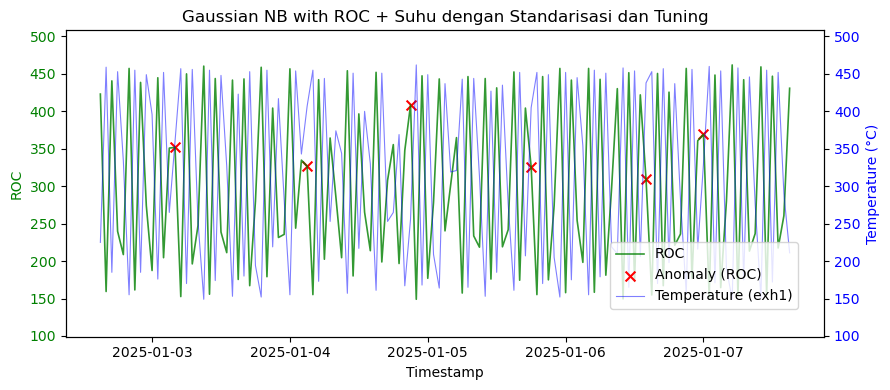

In [256]:
import matplotlib.pyplot as plt
import numpy as np

# Bisa disesuiakn visualisasi dengan train/test data
timestamps = test_results['Timestamp']
temperature_values = test_results['temperature_exh1']
ROC_values = test_results['ROC']
anomalies = test_results['anomaly']  # Kolom 'anomaly' yang sudah ada

# Normalisasi ROC ke dalam rentang suhu
ROC_min, ROC_max = ROC_values.min(), ROC_values.max()
temp_min, temp_max = temperature_values.min(), temperature_values.max()

# Normalisasi ROC menggunakan Min-Max Scaling ke rentang suhu
scaled_ROC_values = (ROC_values - ROC_min) / (ROC_max - ROC_min) * (temp_max - temp_min) + temp_min

# Tentukan rentang yang sama untuk kedua grafik pada sumbu Y
y_min = min(temperature_values.min(), scaled_ROC_values.min()) - 50
y_max = max(temperature_values.max(), scaled_ROC_values.max()) * 1.1

# Buat figure dan axis
fig, ax1 = plt.subplots(figsize=(9, 4))

# Plot ROC yang sudah diskalakan di sumbu kiri dengan garis tipis
ax1.plot(timestamps, scaled_ROC_values, label='ROC', color='green', linestyle='-', alpha=0.8, linewidth=1.2)
ax1.set_ylabel('ROC', color='green')
ax1.tick_params(axis='y', labelcolor='green')
ax1.set_ylim([y_min, y_max])  # Sesuaikan rentang sumbu Y

# Menandai titik anomali pada ROC (berdasarkan kolom anomaly)
ax1.scatter(timestamps[anomalies == 1], scaled_ROC_values[anomalies == 1], 
            color='red', label='Anomaly (ROC)', marker='x', s=50)

# Buat sumbu kanan untuk Temperature (exh1) dengan garis tipis
ax2 = ax1.twinx()
ax2.plot(timestamps, temperature_values, label='Temperature (exh1)', color='blue', alpha=0.5, linewidth=0.8)
ax2.set_ylabel('Temperature (°C)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim([y_min, y_max])  # Sesuaikan rentang sumbu Y agar sejajar

# Tambahkan judul dan legenda
ax1.set_xlabel('Timestamp')
ax1.set_title('Gaussian NB with ROC + Suhu dengan Standarisasi dan Tuning')

# Letakkan legenda di tengah kiri
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.4))

# Rotasi label timestamp agar lebih mudah dibaca
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Tampilkan grafik
plt.show()
